### Descripción del problema

Nota: Funcional. Descartamos las medidas de forest que solo tengan una direccion (up or down).  
Descartamos las medidas con errores de LAI alto.  
Descartamos las medidas con errores de clumping alto (up y down).  
Reservamos las medidas de 2023 para el test final.  
Eliminamos el outlier con id 20190918T154919_20190918T160136_T18SUJ.  
Seleccionamos las medidas insitu con una diferencia de dias menos de 5 dias con respecto a las adquisiciones del satelite.  
Implemento Feature Extraction.

### Variables y librerías

Definimos variables importantes:

In [1409]:
file_name_sat = 'S2_SR_USA_2017_2024_SCL.csv'
#file_name_sat = 'S2_TOArefl_USA_2017_2024.csv'
file_name_insitu = 'NEON_LAI_USA_2017_2024.csv'

Importamos las librerías

In [1410]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn import metrics

from variables import COORDS as coords

In [1411]:
# Montamos nuestro Google Drive si usamos entorno de Colab
#from google.colab import drive
#drive.mount('/content/drive')

### 1. Datos de satelite

#### Cargamos el dataset de datos de satelite

Para entorno de **Google Colab**

In [1412]:
#drive_path = '/content/drive/MyDrive/Colab Notebooks/'
#!ls /content/drive/MyDrive/Colab\ Notebooks/
#dataset_path = drive_path + file_name_sat

Para entorno **local**

In [1413]:
# Definimos ruta de los archivos.
datadir_path = os.path.join('..','data')
dataset_path = os.path.join(datadir_path, file_name_sat)

**Importamos el dataset** con Pandas y visualizamos las primeras instancias

In [1414]:
df_sat = pd.read_csv(dataset_path, sep=',')

# Eliminamos columna innecesaria de indices importado
if 'Unnamed: 0' in df_sat.columns: # Comprobamos si 'Unnamed: 0' está en las columnas
    # Eliminar la columna 'Unnamed: 0'
    df_sat.drop(columns=['Unnamed: 0'], inplace=True) 
df_sat.head(5)

,id,longitude,latitude,time,B1,B2,B3,B4,B5,B6,...,B8,B8A,B9,B11,B12,SCL,QA10,QA20,QA60,Site_sat
0,20171222T182749_20171222T183128_T12TUK,-112.452455,40.177600,1513967574868,3597.0,3704.0,3788.0,3972.0,4316.0,4280.0,...,4272.0,4349.0,4724.0,1167.0,1091.0,11.0,NaN,NaN,0,Onaqui Ault
1,20171118T170559_20171118T170554_T15TYL,-89.586378,45.508922,1511025045890,8393.0,8072.0,7776.0,7568.0,7652.0,7527.0,...,7632.0,7314.0,10924.0,2087.0,2396.0,8.0,NaN,NaN,1024,Steigerwaldt Land Services
2,20171225T165709_20171225T165708_T15TYL,-89.586378,45.508922,1514221250709,3381.0,3469.0,3256.0,3317.0,3473.0,3863.0,...,4376.0,4062.0,3881.0,2315.0,1911.0,9.0,NaN,NaN,2048,Steigerwaldt Land Services
3,20171118T170559_20171118T170554_T15SUD,-95.192225,39.040513,1511025161923,7635.0,7848.0,7632.0,7480.0,7621.0,7438.0,...,7944.0,7295.0,10781.0,1901.0,2098.0,8.0,NaN,NaN,1024,University of Kansas Field Site
4,20171118T170559_20171118T170554_T15TYM,-89.537510,46.234042,1511025031342,5584.0,5352.0,5124.0,5016.0,5094.0,5038.0,...,4980.0,4760.0,6066.0,3001.0,2600.0,9.0,NaN,NaN,1024,Underc


In [1415]:
df_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22975 entries, 0 to 22974
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         22975 non-null  object 
 1   longitude  22975 non-null  float64
 2   latitude   22975 non-null  float64
 3   time       22975 non-null  int64  
 4   B1         22949 non-null  float64
 5   B2         22959 non-null  float64
 6   B3         22960 non-null  float64
 7   B4         22960 non-null  float64
 8   B5         22960 non-null  float64
 9   B6         22960 non-null  float64
 10  B7         22960 non-null  float64
 11  B8         22960 non-null  float64
 12  B8A        22960 non-null  float64
 13  B9         22963 non-null  float64
 14  B11        22960 non-null  float64
 15  B12        22960 non-null  float64
 16  SCL        22960 non-null  float64
 17  QA10       16075 non-null  float64
 18  QA20       16075 non-null  float64
 19  QA60       22975 non-null  int64  
 20  Site_s

#### Limpiamos y procesamos el dataset

Convertimos a tipo **datetime** la columna 'time' que está en formato Unix epoch time.

In [1416]:
#df_sat['time'] = df_sat['time'].apply(lambda x: dt.datetime.utcfromtimestamp(x / 1000))
df_sat['time'] = pd.to_datetime(df_sat['time'], unit='ms')

In [1417]:
df_sat['time']

0       2017-12-22 18:32:54.868
1       2017-11-18 17:10:45.890
2       2017-12-25 17:00:50.709
3       2017-11-18 17:12:41.923
4       2017-11-18 17:10:31.342
                  ...          
22970   2024-12-23 17:00:45.423
22971   2024-12-26 17:10:44.865
22972   2024-12-26 17:10:41.739
22973   2024-12-28 17:00:49.197
22974   2024-12-28 17:00:46.426
Name: time, Length: 22975, dtype: datetime64[ns]

**Ordenamos** el dataframe por Site y time, y **reseteamos** el indice.

In [1418]:
df_sat.sort_values(by=['Site_sat','time'], inplace=True)
df_sat.reset_index(drop=True, inplace=True)

**Eliminamos columnas innecesarias.**  
QA10 y QA20 son columnas vacias.  
También descartamos las bandas de 60m que corresponden a aerosoles y vapor de agua: B1 y B9

In [1419]:
df_sat.drop(columns=['B1', 'B9', 'QA10', 'QA20'], inplace=True)

**Eliminamos las filas** (espectros) correspondientes a **pixeles con nubes**  
Los pixes con nubes corresponden a: QA60 == 512 or QA60 == 1024 or QA60 == 2048  
Por lo tanto nos quedamos solo con los pixeles libres de nubes: QA60 == 0

In [1420]:
len(df_sat) # Antes de eliminar filas vemos el tamaño del dataset

22975

In [1421]:
df_sat['QA60'].value_counts() # También vemos la cantidad de pixeles con nubes

QA60
0       15915
1024     5244
2048     1816
Name: count, dtype: int64

In [1422]:
df_sat = df_sat[df_sat['QA60'] == 0] # Me quedo con las filas (pixeles) libre de nubes

In [1423]:
len(df_sat) # Vemos como queda el tamaño del dataset luego de eliminar pixeles con nubes

15915

**Elimino filas de no-vegetación**  
Me quedo con las filas (pixeles) de vegetación según la banda 'SCL' de Sentinel-2.  
Zonas de vegetación pueden estar cubiertas de nieve en alguna epoca del año.  
Por lo tanto, eliminamos esos pixeles.

In [1424]:
len(df_sat) # Antes de eliminar filas vemos el tamaño del dataset

15915

In [1425]:
df_sat = df_sat[df_sat['SCL'] == 4] # Me quedo con las filas (pixeles) de vegetación

In [1426]:
len(df_sat) # Vemos como queda el tamaño del dataset luego de eliminar pixeles

5547

**Escalamos las bandas** a los valores de reflectancia reales (originalmente están multiplicados por 10000).

In [1427]:
bandas = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12'] # Definimos una lista con las columnas correspondientes a las bandas

In [1428]:
for banda in bandas: # Recorremos todas las bandas
    df_sat.loc[:,banda] = df_sat[banda].astype(float) # Forzamos el tipo de los datos para hacerlos float.
    df_sat.loc[:,banda] = df_sat[banda] * 0.0001 # Escalamos

In [1429]:
# Vemos como queda nuestro dataset
df_sat.head()

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,SCL,QA60,Site_sat
23,20190128T154519_20190128T154758_T19TCJ,-71.287337,44.063892,2019-01-28 15:50:57.000,0.0543,0.0520,0.0584,0.0665,0.1536,0.1727,0.2460,0.2054,0.0793,0.0550,4.0,0,Bartlett Experimental Forest
24,20190128T154519_20190128T154758_T18TYP,-71.287337,44.063892,2019-01-28 15:51:01.000,0.0251,0.0346,0.0358,0.0649,0.1531,0.1739,0.2365,0.2108,0.0815,0.0570,4.0,0,Bartlett Experimental Forest
33,20190222T154241_20190222T154730_T19TCJ,-71.287337,44.063892,2019-02-22 15:50:52.000,0.0642,0.0854,0.0816,0.0890,0.1784,0.2129,0.2199,0.2268,0.1014,0.0616,4.0,0,Bartlett Experimental Forest
34,20190222T154241_20190222T154730_T18TYP,-71.287337,44.063892,2019-02-22 15:50:56.000,0.0438,0.0541,0.0619,0.0842,0.1787,0.2139,0.1845,0.2290,0.1034,0.0623,4.0,0,Bartlett Experimental Forest
63,20190508T153819_20190508T154933_T19TCJ,-71.287337,44.063892,2019-05-08 15:51:05.057,0.0388,0.0560,0.0564,0.0942,0.1683,0.1943,0.2432,0.2120,0.1615,0.0985,4.0,0,Bartlett Experimental Forest


#### Visualización y exploración

Visualizamos muestras de los espectros de vegetación en un gráfico

In [1430]:
# Definimos la longitud de onda central de las bandas
central_wl = {
    'B2': 490,  # Banda 2 (Azul)
    'B3': 560,  # Banda 3 (Verde)
    'B4': 665,  # Banda 4 (Rojo)
    'B5': 705,  # Banda 5
    'B6': 740,  # Banda 6
    'B7': 783,  # Banda 7
    'B8': 842,  # Banda 8 (Infrarrojo cercano)
    'B8A': 865, # Banda 8A
    'B11': 1610, # Banda 11 (Infrarrojo de onda corta)
    'B12': 2190  # Banda 12
}

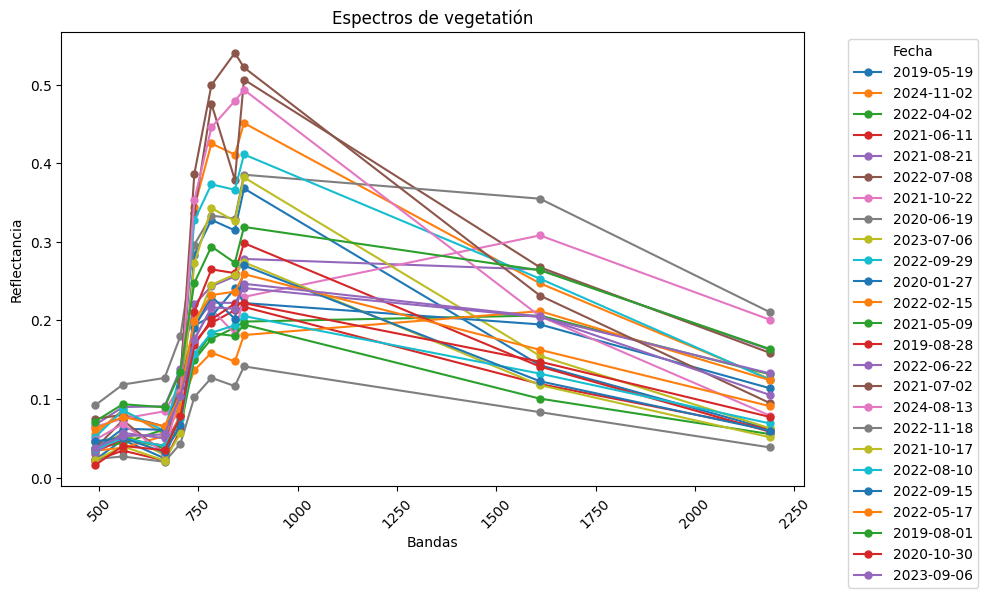

In [1431]:
# Graficar diferentes espectros
plt.figure(figsize=(10, 6))  # Definir tamaño de la figura

for index, row in df_sat.sample(25).iterrows():
    plt.plot([central_wl[band] for band in bandas], row[bandas], label=row['time'].strftime('%Y-%m-%d'), marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("Espectros de vegetatión")
plt.xlabel("Bandas")
plt.ylabel("Reflectancia")
plt.legend(title="Fecha", bbox_to_anchor=(1.05, 1), loc='upper left')  # Mueve la leyenda fuera de la gráfica

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show();

Calculamos el NDVI y graficamos series temporales de muestras de pixeles para verificar que se aproxima a la realidad

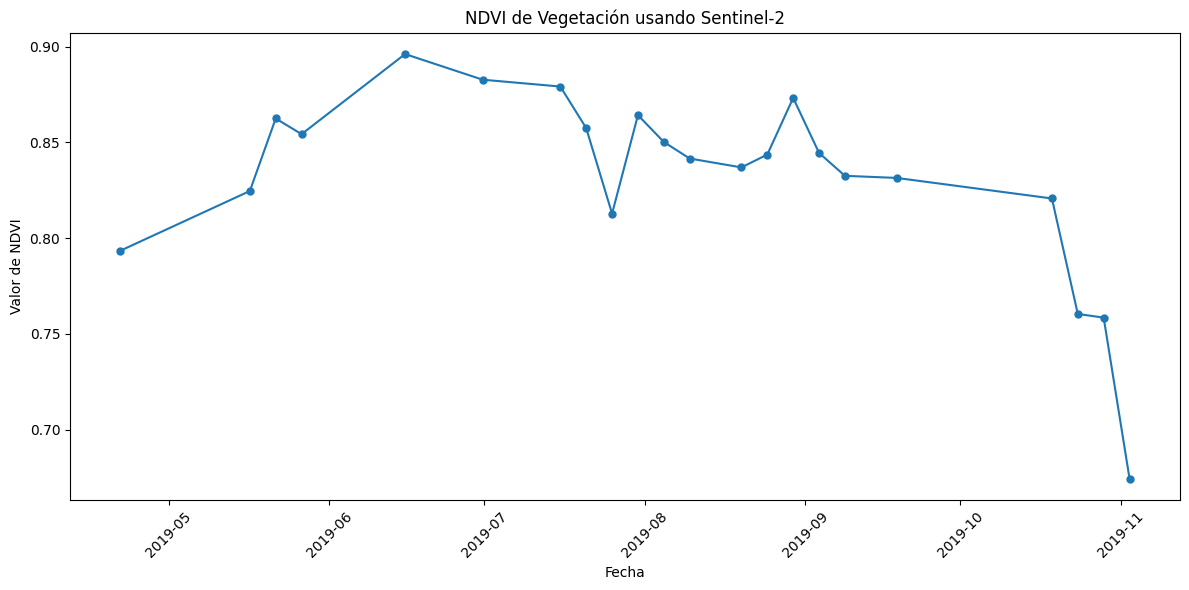

In [1432]:
# Calcular NDVI para cada espectro (fila) del DataFrame
df_VI = df_sat.copy()
df_VI['NDVI'] = (df_VI['B8'] - df_VI['B4']) / (df_VI['B8'] + df_VI['B4'])

# Graficar el NDVI para el site y el año seleccionado
plt.figure(figsize=(12, 6))
mask_Lajas_2019 = (df_VI['Site_sat'] == 'Smithsonian Environmental Research Center') & (df_VI['time'].dt.year == 2019)
plt.plot(df_VI.loc[mask_Lajas_2019,'time'], df_VI.loc[mask_Lajas_2019,'NDVI'], marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("NDVI de Vegetación usando Sentinel-2")
plt.xlabel("Fecha")
plt.ylabel("Valor de NDVI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Image of vegetation phenology

![Image of vegetation phenology](https://www.scielo.org.mx/img/revistas/tl/v36n4//2395-8030-tl-36-04-393-gf1.png)

### 2. Datos de campo

#### Cargamos el dataset de medidas insitu

Para entorno de **Google Colab**

In [1433]:
#drive_path = '/content/drive/MyDrive/Colab Notebooks/'
#!ls /content/drive/MyDrive/Colab\ Notebooks/
#dataset_path_insitu = drive_path + file_name_insitu

Para entorno **local**

In [1434]:
# Definimos ruta de los archivos.
#datadir_path = os.path.join('..','data')
dataset_path_insitu = os.path.join(datadir_path, file_name_insitu)

**Importamos el dataset** con Pandas y visualizamos las primeras instancias

In [1435]:
df_insitu = pd.read_csv(dataset_path_insitu, sep=',')

# Eliminamos columna innecesaria de indices importado
if 'Unnamed: 0' in df_insitu.columns: # Comprobamos si 'Unnamed: 0' está en las columnas
    # Eliminar la columna 'Unnamed: 0'
    df_insitu.drop(columns=['Unnamed: 0'], inplace=True) 
df_sat.head(5)

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,SCL,QA60,Site_sat
23,20190128T154519_20190128T154758_T19TCJ,-71.287337,44.063892,2019-01-28 15:50:57.000,0.0543,0.0520,0.0584,0.0665,0.1536,0.1727,0.2460,0.2054,0.0793,0.0550,4.0,0,Bartlett Experimental Forest
24,20190128T154519_20190128T154758_T18TYP,-71.287337,44.063892,2019-01-28 15:51:01.000,0.0251,0.0346,0.0358,0.0649,0.1531,0.1739,0.2365,0.2108,0.0815,0.0570,4.0,0,Bartlett Experimental Forest
33,20190222T154241_20190222T154730_T19TCJ,-71.287337,44.063892,2019-02-22 15:50:52.000,0.0642,0.0854,0.0816,0.0890,0.1784,0.2129,0.2199,0.2268,0.1014,0.0616,4.0,0,Bartlett Experimental Forest
34,20190222T154241_20190222T154730_T18TYP,-71.287337,44.063892,2019-02-22 15:50:56.000,0.0438,0.0541,0.0619,0.0842,0.1787,0.2139,0.1845,0.2290,0.1034,0.0623,4.0,0,Bartlett Experimental Forest
63,20190508T153819_20190508T154933_T19TCJ,-71.287337,44.063892,2019-05-08 15:51:05.057,0.0388,0.0560,0.0564,0.0942,0.1683,0.1943,0.2432,0.2120,0.1615,0.0985,4.0,0,Bartlett Experimental Forest


In [1436]:
df_insitu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9406 entries, 0 to 9405
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GBOV_ID                   9406 non-null   object 
 1   Site                      9406 non-null   object 
 2   GROUND_DATA_PI            9176 non-null   object 
 3   GROUND_DATA_PIs_Email     9176 non-null   object 
 4   GBOV_Email                9406 non-null   object 
 5   Network                   9406 non-null   object 
 6   Elevation                 9406 non-null   int64  
 7   IGBP_class                9406 non-null   object 
 8   Lat_IS                    9406 non-null   float64
 9   Lon_IS                    9406 non-null   float64
 10  TIME_IS                   9406 non-null   object 
 11  Version                   9406 non-null   float64
 12  up_flag                   7713 non-null   float64
 13  down_flag                 7713 non-null   float64
 14  LAI_Mill

#### Limpiamos y procesamos el dataset

Convertimos a tipo **datetime** la columna 'TIME_IS'

In [1437]:
df_insitu['TIME_IS'] = pd.to_datetime(df_insitu['TIME_IS'])

Pasamos todos los valores **nulos** a NaN

In [1438]:
valores_nulos = [-999.0, 999.0, -999, 999, '-999.0', '999.0', '-999', '999'] # Lista de valores a reemplazar por NaN
df_insitu.replace(valores_nulos, np.nan, inplace=True) # Reemplazar todos los valores por NaN
len(df_insitu)

9406

**Eliminamos filas** fijandonos en las columnas del **quality flag**

In [1439]:
# Nos quedamos con valores de up_flag = 0, que son los de mejor calidad, los demás los marcamos como nulos
mask_invalid_up = df_insitu['up_flag'] != 0
df_insitu.loc[mask_invalid_up,'up_flag'] = np.nan

# Lo mismo para down_flag
mask_invalid_down = df_insitu['down_flag'] != 0
df_insitu.loc[mask_invalid_down,'down_flag'] = np.nan

# Eliminamos filas donde ambas flags son nulas
df_insitu.dropna(subset=['up_flag','down_flag'], how='all', inplace=True)
len(df_insitu)

7486

Definimos las **columnas numéricas**

In [1440]:
col_numericas = [
 'LAI_Miller_up',
 'LAI_Warren_up',
 'LAIe_Miller_up',
 'LAIe_Warren_up',
 'LAI_Miller_down',
 'LAI_Warren_down',
 'LAIe_Miller_down',
 'LAIe_Warren_down',
 'LAI_Miller_up_err',
 'LAI_Warren_up_err',
 'LAIe_Miller_up_err',
 'LAIe_Warren_up_err',
 'clumping_Miller_up',
 'clumping_Warren_up',
 'LAI_Miller_down_err',
 'LAI_Warren_down_err',
 'LAIe_Miller_down_err',
 'LAIe_Warren_down_err',
 'clumping_Miller_down',
 'clumping_Warren_down',
 'clumping_Miller_up_err',
 'clumping_Warren_up_err',
 'clumping_Miller_down_err',
 'clumping_Warren_down_err']

Miramos si existen **caracteres no numericos** en las columnas que impidan convertirlas a float.

In [1441]:
for col in col_numericas:
    # print('\n',col)
    for valor in df_insitu[col]:
        try:
            # Intentar convertir a float, si falla significa que el valor no es numérico
            valor = str(valor)
            float(valor)  # Intentar convertir a float
        except ValueError:
            # Si no se puede convertir, es un valor no numérico
            print(valor)


(7.2
(7.9
(8.0
(8.0
(8
(9
(7.2
(7.9
(8.0
(8.0
(8
(9
1.0)e-05
1.7)e-05
1.7)e-05
1.9)e-05
4)e-05
5)e-05
1.0)e-05
1.7)e-05
1.7)e-05
1.9)e-05
4)e-05
5)e-05


Removemos caracteres no numericos y **forzamos el tipo de datos**

In [1442]:
for col in col_numericas:
    if df_insitu[col].dtypes != 'float':
        #print(col)
        # Limpiamos las columnas numericas de caracteres indeseados.
        df_insitu[col] = df_insitu[col].str.strip().str.replace('(', '').str.replace('(', '').str.replace(')', '')  # .str.replace("[^0-9.e]", '', regex=True)
        #df_insitu[col].astype(float, errors='ignore')
        df_insitu[col] =  pd.to_numeric(df_insitu[col],errors='coerce')


Visualizamos las diferentes clases de cubierta según 'IGBP_class'.  
Definimos las clases que forman parte de forest. 

In [1443]:
df_insitu['IGBP_class'].unique()

array(['Mixed Forest', 'Evergreen Needleleaf', 'Open Shrublands',
       'Croplands', 'Grasslands', 'Deciduous Broadleaf Forest',
       'Evergreen Broadleaf', 'Evergreen Needleleaf Forest',
       'Closed Shrublands', 'Deciduous Broadleaf'], dtype=object)

In [1444]:
class_forest = ['Mixed Forest', 'Evergreen Needleleaf', 'Deciduous Broadleaf Forest', 'Evergreen Broadleaf', 'Evergreen Needleleaf Forest','Deciduous Broadleaf']

Definimos las **quality flags** especificas para las medidas del método Warren ('Warren_up_flag','Warren_down_flag').  
Nos basamos en las quality flags generales ('up_flag' y 'down_flag').

In [1445]:
df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].notnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), ['Warren_up_flag','Warren_down_flag']] = 0

df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].isnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_down_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].isnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_up_flag'] = 0

df_insitu.loc[df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].notnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_up_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].notnull() & (df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'Warren_down_flag'] = 0


df_insitu.loc[(df_insitu['up_flag'] == 0) & df_insitu['down_flag'].isnull(), 'Warren_down_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_up'].notnull() & (df_insitu['up_flag'] == 0) & df_insitu['down_flag'].isnull(), 'Warren_up_flag'] = 0

df_insitu.loc[df_insitu['up_flag'].isnull() & (df_insitu['down_flag'] == 0), 'Warren_up_flag'] = np.nan
df_insitu.loc[df_insitu['LAI_Warren_down'].notnull() & df_insitu['up_flag'].isnull() & df_insitu['down_flag'] == 0, 'Warren_down_flag'] = 0

**Calculamos el LAI y su error** en base a las quality flags.  
**Nota:** Nos quedamos con el LAI de las clases forest solo cuando tiene ambas medidas (LAI up y LAI down).

In [1446]:
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & (df_insitu['Warren_down_flag'] == 0), 'LAI_Warren'] = df_insitu['LAI_Warren_up'] + df_insitu['LAI_Warren_down']
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & (df_insitu['Warren_down_flag'] == 0), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err'] + df_insitu['LAI_Warren_down_err'] 


df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & df_insitu['Warren_down_flag'].isnull() & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos las medidas de forest cuando son solo upwards
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & df_insitu['Warren_down_flag'].isnull() & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = df_insitu['LAI_Warren_up']
df_insitu.loc[(df_insitu['Warren_up_flag'] == 0) & df_insitu['Warren_down_flag'].isnull() & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err']


df_insitu.loc[df_insitu['Warren_up_flag'].isnull() & (df_insitu['Warren_down_flag'] == 0) & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos las medidas de forest cuando son solo downwards
df_insitu.loc[df_insitu['Warren_up_flag'].isnull() & (df_insitu['Warren_down_flag'] == 0) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = df_insitu['LAI_Warren_down']
df_insitu.loc[df_insitu['Warren_up_flag'].isnull() & (df_insitu['Warren_down_flag'] == 0) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren_err'] = df_insitu['LAI_Warren_down_err']


print(df_insitu['LAI_Warren'].isna().sum())

721


Eliminamos filas con **errores** más altos de LAI y de clumpling.

In [1447]:
# Descartamos medidas con errores mas altos
df_insitu = df_insitu[df_insitu['LAI_Warren_err'] <= 0.45]
df_insitu.loc[df_insitu['clumping_Warren_up_err'] >= 0.1,'LAI_Warren'] = np.nan
df_insitu.loc[df_insitu['clumping_Warren_down_err'] >= 0.35, 'LAI_Warren'] = np.nan

In [1448]:
# Eliminamos las filas donde el LAI es nulo
df_insitu.dropna(subset=['LAI_Warren'], inplace=True)
len(df_insitu)

5850

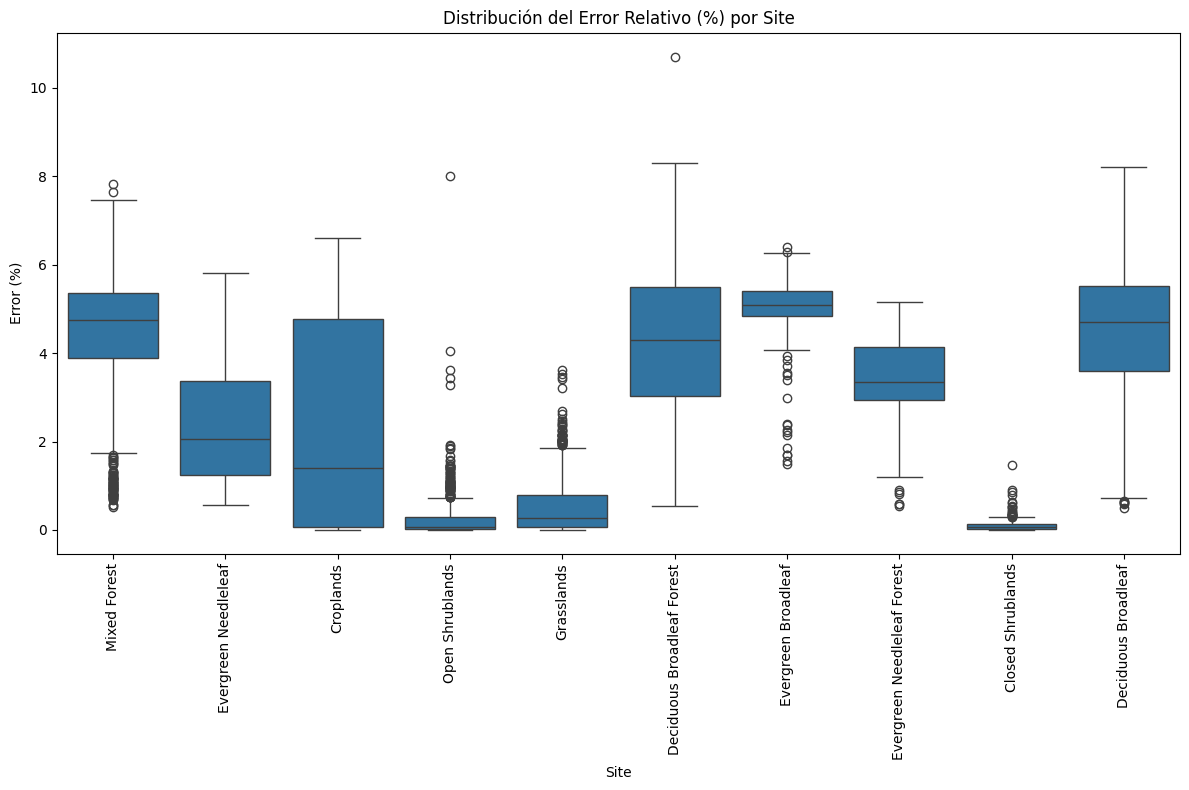

In [1449]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df_insitu, x='IGBP_class', y='LAI_Warren')
plt.xticks(rotation=90)
plt.title('Distribución del Error Relativo (%) por Site')
plt.ylabel('Error (%)')
plt.xlabel('Site')
plt.tight_layout()
plt.show()

<Axes: xlabel='LAI_Warren_err', ylabel='Count'>

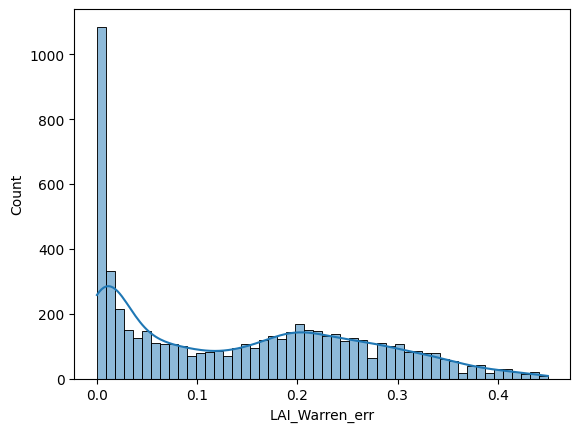

In [1450]:
sns.histplot(df_insitu['LAI_Warren_err'], kde=True, bins=50)

<Axes: xlabel='clumping_Warren_down_err', ylabel='Count'>

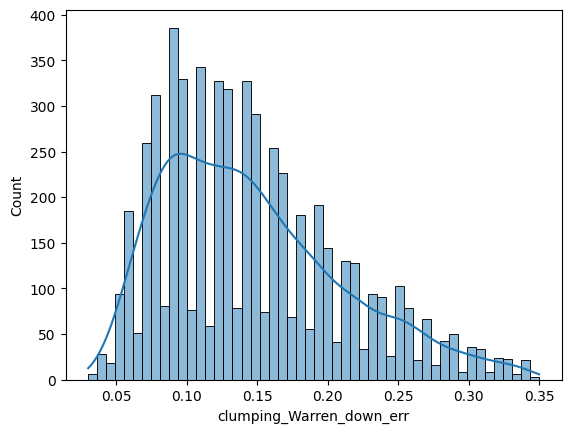

In [1451]:
sns.histplot(df_insitu['clumping_Warren_down_err'], kde=True, bins=50)

<Axes: xlabel='clumping_Warren_up_err', ylabel='Count'>

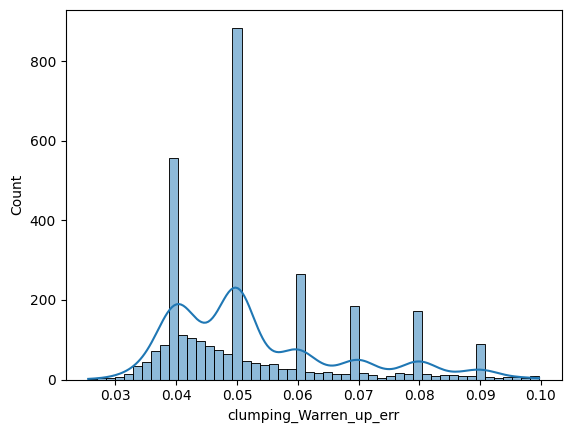

In [1452]:
sns.histplot(df_insitu['clumping_Warren_up_err'], kde=True, bins=50)

Visualizamos la **información** del dataset para  ver como queda.

In [1453]:
df_insitu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5850 entries, 0 to 9404
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   GBOV_ID                   5850 non-null   object             
 1   Site                      5850 non-null   object             
 2   GROUND_DATA_PI            5768 non-null   object             
 3   GROUND_DATA_PIs_Email     5768 non-null   object             
 4   GBOV_Email                5850 non-null   object             
 5   Network                   5850 non-null   object             
 6   Elevation                 5850 non-null   int64              
 7   IGBP_class                5850 non-null   object             
 8   Lat_IS                    5850 non-null   float64            
 9   Lon_IS                    5850 non-null   float64            
 10  TIME_IS                   5850 non-null   datetime64[ns, UTC]
 11  Version               

### 3. Combinación de los datasets

Quitamos el **dato UTC** a la columna fecha para estandarizarla con el dataset de satelite.

In [1454]:
df_insitu[['Site','TIME_IS']].head(2)

,Site,TIME_IS
0,Harvard Forest,2018-08-13 00:00:00+00:00
2,Harvard Forest,2018-08-13 00:00:00+00:00


In [1455]:
df_insitu['TIME_IS'] = pd.to_datetime(df_insitu['TIME_IS']).dt.tz_localize(None)
df_insitu[['Site','TIME_IS']].head(2)

,Site,TIME_IS
0,Harvard Forest,2018-08-13
2,Harvard Forest,2018-08-13


**Merge de data sets**. Para cada site identificamos las medidas in_situ mas cercanas a la fecha de adquisicion del satélite

In [1456]:
df_list = []
days_diff_max = 5 # Diferencia maxima (en días) entre la medida de satelite y la medida in situ

# Itera sobre cada coordenada
for site, lat, lon in coords:
    # Filtra el DataFrame de df_insitu y df_sat según el 'Site'
    df_insitu_site = df_insitu[df_insitu['Site'] == site]
    df_sat_site = df_sat[df_sat['Site_sat'] == site]

    rows = []

    # Itera sobre los datos de satélite y sobre los datos in situ
    for index_sat, date_sat in df_sat_site['time'].items():
        for index_insitu, date_insitu in df_insitu_site['TIME_IS'].items():
            # Calcula la diferencia en días entre las fechas
            dif = (date_insitu - date_sat) / np.timedelta64(1, 'D')

            if abs(dif) <= days_diff_max: # Si la diferencia en dias es menor...
                # Crea una lista con la fila combinada de ambas fuentes de datos
                row = list(df_sat_site.loc[index_sat]) + list(df_insitu_site.loc[index_insitu])
                rows.append(row)

    # Si se encontraron filas, procesa los datos
    if rows:
        # Crear el DataFrame con las filas acumuladas
        df_cross_site = pd.DataFrame(rows, columns=list(df_sat_site.columns) + list(df_insitu_site.columns))

        # Añadir una columna 'delta' con la diferencia en tiempo entre el satélite y las mediciones in situ
        df_cross_site['delta'] = abs(df_cross_site['time'] - df_cross_site['TIME_IS'])

        # Añadir las fechas separadas de 'date_sat' y 'date_insitu'
        df_cross_site['date_sat'] = df_cross_site['time'].dt.date
        df_cross_site['date_insitu'] = df_cross_site['TIME_IS'].dt.date

        # Ordenar y eliminar duplicados por 'date_insitu'
        df_cross_site = df_cross_site.sort_values(by=['date_insitu', 'delta']).drop_duplicates(subset='date_insitu', keep='first')

        # Ordenar y eliminar duplicados por 'date_sat'
        df_cross_site = df_cross_site.sort_values(by=['date_sat', 'delta']).drop_duplicates(subset='date_sat', keep='first')


        # Agregar el DataFrame de este sitio a la lista
        df_list.append(df_cross_site)

# Combinar todos los DataFrames en uno solo
df_cross = pd.concat(df_list, axis=0, ignore_index=True)


Vemos el resultado del dataset combinado (solo algunas columnas)

In [1457]:
#df_cross = df_cross.sort_values(by = ['Site','time']).reset_index(drop=True) # Reordenamos por Site y time del satelite
df_cross[['Site','date_sat','date_insitu','delta']]

,Site,date_sat,date_insitu,delta
0,Harvard Forest,2019-06-07,2019-06-04,3 days 10:17:23
1,Harvard Forest,2019-06-27,2019-07-02,4 days 13:44:37
2,Harvard Forest,2019-07-12,2019-07-16,3 days 13:53:39.569000
3,Harvard Forest,2019-08-01,2019-07-30,2 days 09:45:19.875000
4,Harvard Forest,2019-08-26,2019-08-27,0 days 14:23:40.257000
...,...,...,...,...
828,Disney Wilderness Preserve,2023-08-11,2023-08-08,3 days 04:05:34.663000
829,Disney Wilderness Preserve,2023-08-21,2023-08-22,0 days 18:58:26.181000
830,Disney Wilderness Preserve,2023-09-20,2023-09-18,2 days 01:48:32.699000
831,Disney Wilderness Preserve,2023-10-05,2023-10-03,2 days 00:55:30.152000


In [1458]:
df_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   id                        833 non-null    object         
 1   longitude                 833 non-null    float64        
 2   latitude                  833 non-null    float64        
 3   time                      833 non-null    datetime64[ns] 
 4   B2                        833 non-null    float64        
 5   B3                        833 non-null    float64        
 6   B4                        833 non-null    float64        
 7   B5                        833 non-null    float64        
 8   B6                        833 non-null    float64        
 9   B7                        833 non-null    float64        
 10  B8                        833 non-null    float64        
 11  B8A                       833 non-null    float64        
 12  B11     

Graficamos espectros de vegetación correspondientes a diferentes valores de LAI

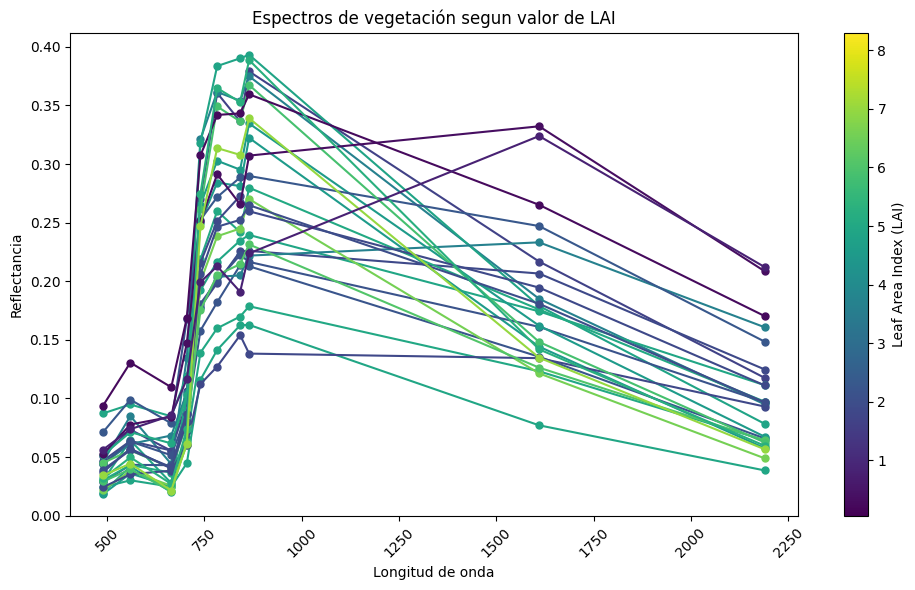

In [1459]:
# Graficar diferentes espectros
fig, ax = plt.subplots(figsize=(10, 6))

# Crear una lista de colores basada en el valor de LAI
cmap = plt.get_cmap('viridis')  # Elegir un mapa de colores
norm = plt.Normalize(df_cross['LAI_Warren'].min(), df_cross['LAI_Warren'].max())  # Normalizar el rango del LAI

for index, row in df_cross.sample(25).iterrows():
    # Obtener el valor del LAI para esta fila
    lai_value = row['LAI_Warren']

    # Mapear el valor de LAI a un color
    color = cmap(norm(lai_value))  # Obtener el color correspondiente al LAI

    # Graficar el espectro, usando el valor del LAI como color de la línea
    ax.plot([central_wl[band] for band in bandas], row[bandas], label=row['date_sat'].strftime('%Y-%m-%d'),
             marker='o', linestyle='-', markersize=5, color=color)

# Añadir barra de colores para mostrar la escala del LAI
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para la barra de colores
fig.colorbar(sm, ax=ax, label='Leaf Area Index (LAI)') # Associate colorbar with the axes

# Configuración del gráfico
ax.set_title("Espectros de vegetación segun valor de LAI") # Use ax.set_title instead of plt.title
ax.set_xlabel("Longitud de onda") # Use ax.set_xlabel instead of plt.xlabel
ax.set_ylabel("Reflectancia") # Use ax.set_ylabel instead of plt.ylabel

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show()

Nos quedamos con los datos del 2017 al 2023. Reservamos los del 2024 para test final.

In [1460]:
df_cross = df_cross[pd.to_datetime(df_cross['date_insitu']) < pd.to_datetime('2023-01-01')]

Exportamos el dataframe a un archivo csv (opcional).

In [1461]:
#df_cross.to_csv(drive_path + 'Sentinel2_SR_NEON_USA_LAI_2017_2023.csv')

### 4. Mini EDA

Verificamos si hay nulos en las bandas y en el target. Y los eliminamos.

In [1462]:
print(df_cross[bandas].isna().sum())
print('\nTarget:',df_cross['LAI_Warren'].isna().sum())
df_cross.dropna(subset=bandas, how='any', inplace=True)
df_cross.dropna(subset='LAI_Warren', inplace=True)

B2     0
B3     0
B4     0
B5     0
B6     0
B7     0
B8     0
B8A    0
B11    0
B12    0
dtype: int64

Target: 0


Definimos variables a excluir

In [1463]:
features_sel = ['Site',
 'Lat_IS',
 'Lon_IS',
 'date_sat',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B11',
 'B12',
 'NDVI',
 'Network',
 'Elevation',
 'IGBP_class',
 'date_insitu',
 'delta',
 'LAIe_Miller',
 'LAIe_Miller_err']

#### Dividimos en train y test 

Estratificamos por la variable 'IGBP_class' que corresponde a los tipos de cubierta de vegetación.

In [1464]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_cross, test_size=0.2, stratify=df_cross['IGBP_class'] ,random_state=42)
print(len(train_set))
print(len(test_set))

584
146


#### Definimos el target y vemos su distribución

Nuestra variable objetivo es el Leaf Area Index correspondiente al método Warren.

In [1465]:
target = 'LAI_Warren'

Vemos la distribución de la variable objetivo.  
Lamentablemente no tiene una distribución gausiana, lo que puede afectar a algunos modelos como el de regresion lineal.

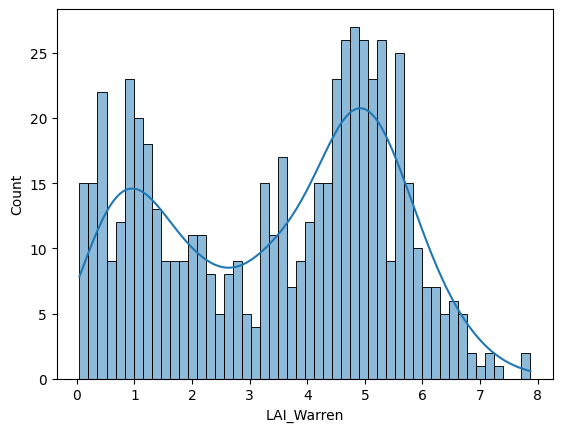

In [1466]:
sns.histplot(x= target, data = train_set, kde = True, bins=50);

#### Comprensión de variables

In [1467]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 584 entries, 192 to 116
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   id                        584 non-null    object         
 1   longitude                 584 non-null    float64        
 2   latitude                  584 non-null    float64        
 3   time                      584 non-null    datetime64[ns] 
 4   B2                        584 non-null    float64        
 5   B3                        584 non-null    float64        
 6   B4                        584 non-null    float64        
 7   B5                        584 non-null    float64        
 8   B6                        584 non-null    float64        
 9   B7                        584 non-null    float64        
 10  B8                        584 non-null    float64        
 11  B8A                       584 non-null    float64        
 12  B11        

#### Feature reduction preliminar

De todas las features nos quedamos solo con las bandas del satélite, pues no queremos que nuestro modelo dependa de datos de coordenadas, fecha, clase de cubierta.  
Es decir, debemos ser capaces de predecir el LAI a partir solo de los espectros. 

Seleccionamos las 10 bandas:

In [1468]:
features = bandas
features

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

### Nulos y duplicados

Verificamos si hay nulos en las bandas y en el target. Y los eliminamos.

In [1469]:
print(train_set[bandas].isna().sum())
print('Target:',train_set['LAI_Warren'].isna().sum())
#train_set.dropna(subset=bandas, how='any', inplace=True)
#train_set.dropna(subset='LAI_Warren', inplace=True)
print('\n')

print(test_set[bandas].isna().sum())
print('Target:',test_set['LAI_Warren'].isna().sum())
#test_set.dropna(subset=bandas, how='any', inplace=True)
#test_set.dropna(subset='LAI_Warren', inplace=True)

B2     0
B3     0
B4     0
B5     0
B6     0
B7     0
B8     0
B8A    0
B11    0
B12    0
dtype: int64
Target: 0


B2     0
B3     0
B4     0
B5     0
B6     0
B7     0
B8     0
B8A    0
B11    0
B12    0
dtype: int64
Target: 0


Verificamos si hay duplicados

In [1470]:
print(train_set.duplicated(subset=bandas, keep='first').sum())
print(test_set.duplicated(subset=bandas, keep='first').sum())

0
0


### Tratamos los outliers

In [1471]:
#Eliminamos un outlier que hemos identificado
#df_cross = df_cross[~(df_cross['id'] == '20190918T154919_20190918T160136_T18SUJ')]

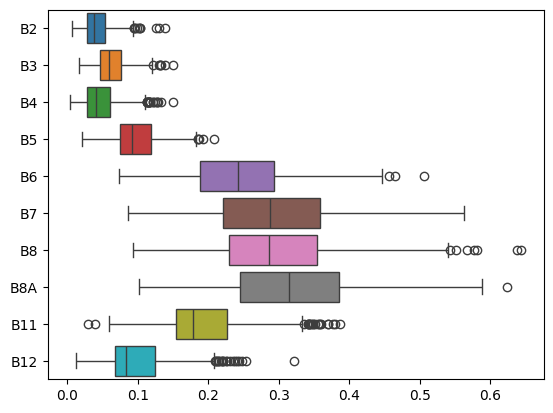

In [1472]:
sns.boxplot(data = train_set[features], orient = "h");

In [1473]:
#sns.boxplot(data = train_set['B11'], orient = "h");

In [1474]:
B2_umbral = 0.12
B3_umbral = 0.14
B4_umbral = 0.14
B5_umbral = 0.20
B6_umbral = 0.43
B8_umbral = 0.55
B11_umbral = 0.37
B12_umbral = 0.30
B11_umbral_inf = 0.05
train_set = train_set[train_set['B2'] < B2_umbral]
train_set = train_set[train_set['B3'] < B3_umbral]
train_set = train_set[train_set['B4'] < B4_umbral]
train_set = train_set[train_set['B5'] < B5_umbral]
train_set = train_set[train_set['B6'] < B6_umbral]
train_set = train_set[train_set['B8'] < B8_umbral]
train_set = train_set[train_set['B11'] < B11_umbral]
train_set = train_set[train_set['B12'] < B12_umbral]
train_set = train_set[train_set['B11'] > B11_umbral_inf]
len(train_set)

567

### Preparacion de features

#### Definimos X_train, y_train

In [1475]:
X_train = train_set[features]
y_train = train_set[target]

X_test = test_set[features]
y_test = test_set[target]

#### Escalamos las features numericas (bandas) con un standar escalar. Necesario para modelos como la regresión lineal.

In [1476]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[bandas]), columns=bandas)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[bandas]), columns=bandas)

### Construccion de modelo base

#### Instanciamos y entrenamos una Linear regression

In [1477]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled,y_train)


LinearRegression()

Resultados para **train**

In [1478]:
y_pred = lin_reg.predict(X_train_scaled)

In [1479]:
argumentos = (y_train, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_train_scaled, y_train))

MSE: 1.0441308282471875
RMSE: 1.0218272007767202
MAE: 0.8147318726563004
MAPE: 0.6670824365568091
R2: 0.7266065443357697


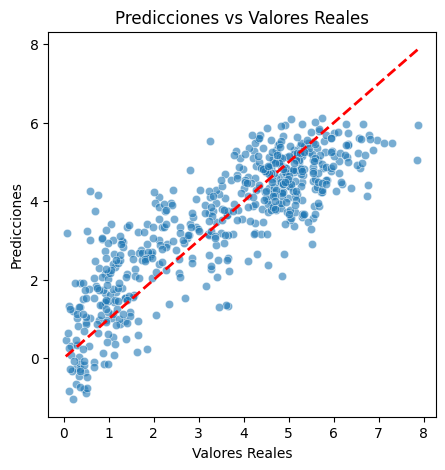

In [1480]:
# Crear el gráfico de dispersión
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_train, y=y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

Resultados para **test**

In [1481]:
y_pred = lin_reg.predict(X_test_scaled)

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_test_scaled, y_test))

MSE: 1.28828200829321
RMSE: 1.135025113507719
MAE: 0.8793250871102978
MAPE: 0.6840583862200261
R2: 0.6798923165080257


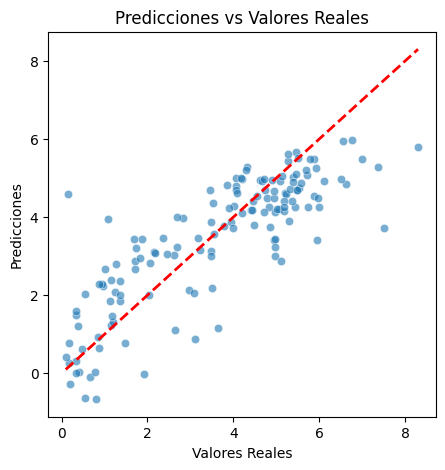

In [1482]:
# Crear el gráfico de dispersión
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

Calculamos el uncertainty agreement ratio (UAR) was also calculated, corresponding to the percentage of retrievals falling within 1 unit.

In [1483]:
# Variable para contar cuántos valores de y_pred están dentro del 15% de y_test
count = 0

# Iterar a través de los elementos de y_test y y_pred
for y_t, y_p in zip(y_test, y_pred):
    if abs(y_p - y_t) <= 1:
        count += 1

print(f"Cantidad de valores de y_pred dentro de la unidad: {count}")

Cantidad de valores de y_pred dentro de la unidad: 96


In [1484]:
len(y_test)

146

In [1485]:
UAR = count/len(y_test)
UAR

0.6575342465753424

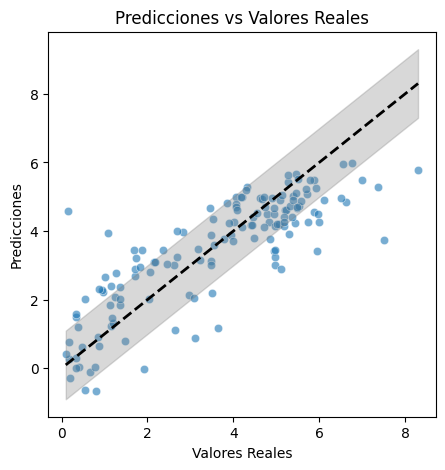

In [1486]:
# Crear el gráfico de dispersión
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

# Sombrear el área entre las dos líneas paralelas (±1) en gris
plt.fill_between([y_test.min(), y_test.max()], 
                 [y_test.min() - 1, y_test.max() - 1], 
                 [y_test.min() + 1, y_test.max() + 1], 
                 color='gray', alpha=0.3)

# Línea diagonal que indica predicciones perfectas
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')

# Mostrar el gráfico
plt.show()

### Feature reduction

a) Selección de las mejores features con **análisis visual**

Aplicamos el test de significación de la correlación de Pearson, acudiendo a Scipy.  
Vemos que para todas las bandas pvalue  tien un  nivel de significacion deseado menor que 1. Lo que nos lleva a aceptar la hipotesis alternativa de que existe correlación significativa entre las features.

In [1487]:
from scipy.stats import  pearsonr

for col in bandas:
    print(col)
    print(pearsonr(train_set["LAI_Warren"], train_set[col]))

B2
PearsonRResult(statistic=-0.4026363207248131, pvalue=1.6458415885032373e-23)
B3
PearsonRResult(statistic=-0.4654395604245438, pvalue=7.946367076618994e-32)
B4
PearsonRResult(statistic=-0.6635242396876454, pvalue=3.221605819270568e-73)
B5
PearsonRResult(statistic=-0.5787632882749656, pvalue=5.187144246671359e-52)
B6
PearsonRResult(statistic=0.19898608529366915, pvalue=1.7918053150357042e-06)
B7
PearsonRResult(statistic=0.27544823503945876, pvalue=2.489830134907713e-11)
B8
PearsonRResult(statistic=0.2634470231359708, pvalue=1.8633493835451277e-10)
B8A
PearsonRResult(statistic=0.25435621465159897, pvalue=8.014155247402547e-10)
B11
PearsonRResult(statistic=-0.6333338923525932, pvalue=6.6546759784144185e-65)
B12
PearsonRResult(statistic=-0.7394127147575159, pvalue=3.7734188178014514e-99)


Vemos las features (bandas) mas correlacionadas con el target usando el metodo de Pandas corr que calcula el coeficiente de correlación de Pearson.  
Vemos que las bandas mas correlacionadas con el target son  las B12, B4, B11 y B5. Y las que menos la B6, B8A, B8 y B7.

In [1488]:
corr = train_set[features + [target]].corr()
np.abs(corr[target].sort_values(ascending = False))

LAI_Warren    1.000000
B7            0.275448
B8            0.263447
B8A           0.254356
B6            0.198986
B2            0.402636
B3            0.465440
B5            0.578763
B11           0.633334
B4            0.663524
B12           0.739413
Name: LAI_Warren, dtype: float64

<Axes: >

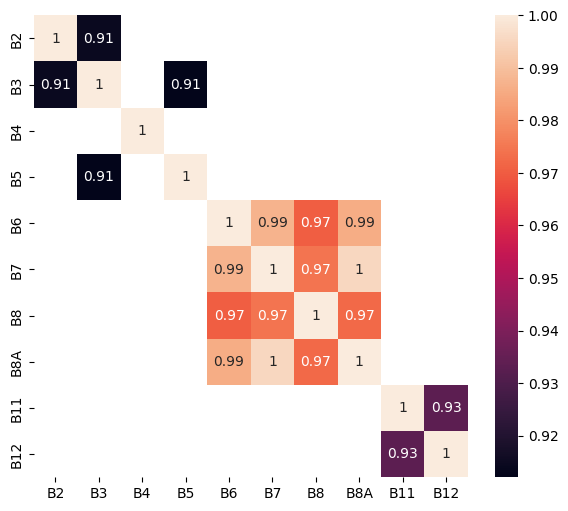

In [1489]:
corr = train_set[features].corr()
high_corr = corr[abs(corr) > 0.9]
plt.figure(figsize=(7,6))
sns.heatmap(abs(high_corr), annot=True)

La más alta correlación entre bandas es:  
B7-B8A del 100%.  
B6-B7 del 99%.  
B6-B8A del 99%.  
B7-B8 del 98%.  
B6-B8 del 97%.  
B8-B8A del 97%.


Descarto B8A, B6, B7 que tienen una alta correlacion y son las que menos correlación tienen con el target.  
También descarto B3 porque tiene alto correlación con B2 y B5.

In [1490]:
bandas_eliminar = ['B6','B8A', 'B7', 'B3']
bandas_sel = [banda for banda in bandas if banda not in bandas_eliminar]
bandas_sel

['B2', 'B4', 'B5', 'B8', 'B11', 'B12']

In [1491]:
X_train_visual = X_train[bandas_sel]
X_train_scaled_visual = X_train_scaled[bandas_sel]
X_train_scaled_visual.columns.to_list()

['B2', 'B4', 'B5', 'B8', 'B11', 'B12']

In [1492]:
from sklearn.ensemble import RandomForestRegressor

X = X_train[features]
Y = y_train

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X, Y)

names = X.columns
scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
feat_score = pd.DataFrame(scores, columns=['Score', 'Feature'])
feat_score

,Score,Feature
0,0.6419,B12
1,0.0851,B8A
2,0.0586,B11
3,0.0426,B7
4,0.0425,B2
5,0.0326,B5
6,0.0270,B4
7,0.0260,B3
8,0.0226,B8
9,0.0211,B6


In [1493]:
X_train_selector = X_train[['B2','B5','B7','B8A','B11','B12']]
X_train_scaled_selector = X_train_scaled[['B2','B5','B7','B8A','B11','B12']]
X_train_scaled_selector.columns.to_list()

['B2', 'B5', 'B7', 'B8A', 'B11', 'B12']

b) Selección de las mejores features usando un **modelo intermedio**

Selección de las mejores features a través de un modelo intermedio (usando **SelectFromModel**).  
Seleccionamos las bandas que queden con una importancia por encima de la mediana.

In [1494]:
'''from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

rf_selector = RandomForestRegressor(max_depth=5,random_state= 42)

selector_model = SelectFromModel(estimator = rf_selector, threshold= "median")
selector_model.fit(X_train,y_train) 
selector_model.get_feature_names_out()
X_train_selector = pd.DataFrame(selector_model.transform(X_train), columns = selector_model.get_feature_names_out())
X_train_scaled_selector = pd.DataFrame(selector_model.transform(X_train_scaled), columns = selector_model.get_feature_names_out())
X_train_scaled_selector'''

'from sklearn.ensemble import RandomForestRegressor\nfrom sklearn.feature_selection import SelectFromModel\n\nrf_selector = RandomForestRegressor(max_depth=5,random_state= 42)\n\nselector_model = SelectFromModel(estimator = rf_selector, threshold= "median")\nselector_model.fit(X_train,y_train) \nselector_model.get_feature_names_out()\nX_train_selector = pd.DataFrame(selector_model.transform(X_train), columns = selector_model.get_feature_names_out())\nX_train_scaled_selector = pd.DataFrame(selector_model.transform(X_train_scaled), columns = selector_model.get_feature_names_out())\nX_train_scaled_selector'

c) Selección de las mejores features empleando **RFE**

In [1495]:
from sklearn.feature_selection import RFE

rf_RFE = RandomForestRegressor(max_depth=5, random_state= 42)

rfe = RFE(estimator = rf_RFE,
          n_features_to_select= 6, # Iterará hasta quedarse con 6
          step = 1) # Elimina de una en una, pero es configurable

rfe.fit(X_train, y_train)
print(rfe.ranking_)
pd.DataFrame(rfe.ranking_, columns= ["ranking"], index = X_train.columns).sort_values("ranking")

[1 5 2 1 3 1 4 1 1 1]


,ranking
B2,1
B5,1
B7,1
B8A,1
B11,1
B12,1
B4,2
B6,3
B8,4
B3,5


In [1496]:
X_train_rfe = pd.DataFrame(rfe.transform(X_train), columns = rfe.get_feature_names_out())
X_train_scaled_rfe = pd.DataFrame(rfe.transform(X_train_scaled), columns = rfe.get_feature_names_out())
X_train_rfe.columns.to_list()

['B2', 'B5', 'B7', 'B8A', 'B11', 'B12']

d) Selección de las mejores features empleando **SFS**

In [1497]:
from sklearn.feature_selection import SequentialFeatureSelector

rf_SFS = RandomForestRegressor(max_depth=5,random_state = 42)

sfs_forward = SequentialFeatureSelector(rf_SFS,
                                        n_features_to_select = 6,
                                        cv = 5,
                                        scoring = "neg_mean_absolute_percentage_error")


sfs_forward.fit(X_train, y_train)

SequentialFeatureSelector(estimator=RandomForestRegressor(max_depth=5,
                                                          random_state=42),
                          n_features_to_select=6,
                          scoring='neg_mean_absolute_percentage_error')

In [1498]:
X_train_sfs = pd.DataFrame(sfs_forward.transform(X_train), columns = sfs_forward.get_feature_names_out())
X_train_scaled_sfs = pd.DataFrame(sfs_forward.transform(X_train_scaled), columns = sfs_forward.get_feature_names_out())
X_train_sfs.columns.to_list()

['B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

Selección de las mejores features mediante un sistema de **hard-voting** aplicado a lo obtenido en los pasos 1 a 5 anteriores.

In [1499]:
from collections import Counter

# Unir todas las listas
all_features = X_train_selector.columns.to_list() + X_train_rfe.columns.to_list() + X_train_sfs.columns.to_list()

# Contar la frecuencia de cada feature
feature_counts = Counter(all_features)

# Ordenar las features por frecuencia
sorted_features = [feature for feature, count in feature_counts.most_common()]

# Mostrar la lista definitiva de features
print("Lista definitiva de features ordenadas por popularidad:")
sorted_features


Lista definitiva de features ordenadas por popularidad:


['B7', 'B8A', 'B11', 'B12', 'B2', 'B5', 'B6', 'B8']

In [1500]:
feature_counts

Counter({'B7': 3,
         'B8A': 3,
         'B11': 3,
         'B12': 3,
         'B2': 2,
         'B5': 2,
         'B6': 1,
         'B8': 1})

In [1501]:
X_train_hvote = X_train[['B2','B5','B7','B8A','B11','B12']]
X_train_scaled_hvote = X_train_scaled[['B2','B5','B7','B8A','B11','B12']]

### Probar varios modelos (pre-optimización)

Comparación de modelos y diferentes features selection con Validación Cruzada 

In [1502]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

model_names = ["Regresion Lineal","Ridge", "Lasso", "ElasticNet", "SVM","Random Forest","XGBoost","LightGBM","CatBoost"]

lr = LinearRegression()
ridgeR = Ridge(random_state=42)
lassoR = Lasso(alpha=0.01, random_state=42)
elastic_net = ElasticNet(alpha= 0.01, l1_ratio= 0.5, random_state=42)
rf = RandomForestRegressor(random_state= 42)
xgb = XGBRegressor(random_state = 42)
lgb = LGBMRegressor(random_state= 42, verbose = -100)
cat  = CatBoostRegressor(random_state= 42, verbose = False)
svr = SVR()

model_set = [lr, ridgeR, lassoR, elastic_net, svr, rf, xgb, lgb, cat]


metricas_cv = {}
valores = []
for nombre_modelo,modelo in zip(model_names, model_set):

    for nombre,set,set_scaled in zip(["Visual","SelectedFromModel", 'RFE', 'SFS','Hard voting',"Full_num_features"],[X_train_visual,  X_train_selector, X_train_rfe, X_train_sfs, X_train_hvote, X_train],[X_train_scaled_visual,  X_train_scaled_selector, X_train_scaled_rfe, X_train_scaled_sfs, X_train_scaled_hvote, X_train_scaled]):
        combinacion = nombre_modelo + "-" + nombre
        print(f"Para <{combinacion}> con <num_features: {len(set.columns.to_list())}>")
        print(modelo)
    
        if nombre_modelo not in ["Regresion Lineal", "Ridge", "Lasso", "ElasticNet", "SVM"]:
            metricas_cv[combinacion] = cross_val_score(modelo, set, y_train, cv = 3, scoring = "neg_mean_absolute_percentage_error")
        else:
            metricas_cv[combinacion] = cross_val_score(modelo, set_scaled, y_train, cv = 3, scoring = "neg_mean_absolute_percentage_error") 
        print(-np.mean(metricas_cv[combinacion]), "\n")
        valores.append(-np.mean(metricas_cv[combinacion]))
ganador = list(metricas_cv.keys())[np.argmin(valores)]
best_score = np.min(valores)

Para <Regresion Lineal-Visual> con <num_features: 6>
LinearRegression()
0.6938416423749246 

Para <Regresion Lineal-SelectedFromModel> con <num_features: 6>
LinearRegression()
0.6836126659219598 

Para <Regresion Lineal-RFE> con <num_features: 6>
LinearRegression()
0.6836126659219598 

Para <Regresion Lineal-SFS> con <num_features: 6>
LinearRegression()
0.7040719395031676 

Para <Regresion Lineal-Hard voting> con <num_features: 6>
LinearRegression()
0.6836126659219598 

Para <Regresion Lineal-Full_num_features> con <num_features: 10>
LinearRegression()
0.6775643283635545 

Para <Ridge-Visual> con <num_features: 6>
Ridge(random_state=42)
0.6915179217511307 

Para <Ridge-SelectedFromModel> con <num_features: 6>
Ridge(random_state=42)
0.6794756668936026 

Para <Ridge-RFE> con <num_features: 6>
Ridge(random_state=42)
0.6794756668936026 

Para <Ridge-SFS> con <num_features: 6>
Ridge(random_state=42)
0.6971516416981478 

Para <Ridge-Hard voting> con <num_features: 6>
Ridge(random_state=42)
0

In [1503]:
# Calcular la media de los valores
mean_values = {key: -np.mean(value) for key, value in metricas_cv.items()}

# Ordenar por media en orden descendente
sorted_mean_values = dict(sorted(mean_values.items(), key=lambda item: item[1]))

# Imprimir los resultados
for model, mean in sorted_mean_values.items():
    print(f"{model}: {mean:.4f}")

SVM-SFS: 0.4971
SVM-Full_num_features: 0.5058
SVM-SelectedFromModel: 0.5092
SVM-RFE: 0.5092
SVM-Hard voting: 0.5092
LightGBM-SFS: 0.5093
CatBoost-SFS: 0.5095
SVM-Visual: 0.5176
LightGBM-Full_num_features: 0.5219
CatBoost-SelectedFromModel: 0.5221
CatBoost-RFE: 0.5221
CatBoost-Hard voting: 0.5221
LightGBM-SelectedFromModel: 0.5331
LightGBM-RFE: 0.5331
LightGBM-Hard voting: 0.5331
Random Forest-SFS: 0.5413
CatBoost-Full_num_features: 0.5439
XGBoost-SFS: 0.5572
CatBoost-Visual: 0.5614
Random Forest-SelectedFromModel: 0.5682
Random Forest-RFE: 0.5682
Random Forest-Hard voting: 0.5682
Random Forest-Full_num_features: 0.5707
XGBoost-Full_num_features: 0.5765
XGBoost-SelectedFromModel: 0.5808
XGBoost-RFE: 0.5808
XGBoost-Hard voting: 0.5808
LightGBM-Visual: 0.5818
XGBoost-Visual: 0.5916
Random Forest-Visual: 0.5951
ElasticNet-Full_num_features: 0.6714
Ridge-Full_num_features: 0.6749
ElasticNet-SelectedFromModel: 0.6758
ElasticNet-RFE: 0.6758
ElasticNet-Hard voting: 0.6758
Lasso-Full_num_featur

In [1504]:
print(f"El ganador es {ganador} con {best_score.round(4)}")

El ganador es SVM-SFS con 0.4971


En  principio, viendo la validación cruzada (**contra train**) se observa que usando la feature selection tenemos mejores resultados que usando todas las features.  
Y de los metodos el que ligeramente resalta es el SFS.   

Y claramente, de todos los modelos de ML, la regresion lineal y sus variantes (Ridge, Lasso y Elastic Net) muestran los peores resultados. 

El ganador es el **SVM-SFS**.

Pero antes hay que probar **contra test** a ver si mejora con respecto al modelo base.

In [1505]:
regr = SVR()
regr.fit(X_train_scaled_sfs, y_train)

y_pred = regr.predict(X_test_scaled[X_train_scaled_sfs.columns])

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', regr.score(X_test_scaled[X_train_scaled_sfs.columns], y_test))

MSE: 1.4437829832975142
RMSE: 1.201575209172324
MAE: 0.8275794670450337
MAPE: 0.5829550394915322
R2: 0.6412539930905321


Efectivamente, el SVR con feature reduction SFS (MAPE: 0.5830) muestra mejor desempeño que el modelo base de linear regression (MAPE: 0.6841).  
Sin embargo, en términos de RMSE la regresión lineal (RMSE: 1.1350) muestra mejor resultado que el SVR (RMSE: 1.2015)

Nos quedaremos con el modelo de **regresion lineal** por ser más sencillo y porque considerando ambas métricas las diferencias no son muy determinantes.

No usaremos la feature selection ya que la regresion lineal mostró mejor desempeño usando **todas las features**.


### Modelo final

Usamos el modelo de regresion lineal con todas las bandas y graficamos las predicciones vs los valores reales, identificados por su tipo de cubierta.

In [1506]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled,y_train)

LinearRegression()

In [1507]:
y_pred = lin_reg.predict(X_test_scaled)

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_test_scaled, y_test))

MSE: 1.28828200829321
RMSE: 1.135025113507719
MAE: 0.8793250871102978
MAPE: 0.6840583862200261
R2: 0.6798923165080257


In [1508]:
df_result = pd.DataFrame(y_test)
df_result['pred'] = y_pred
df_result['Class'] = test_set['IGBP_class']

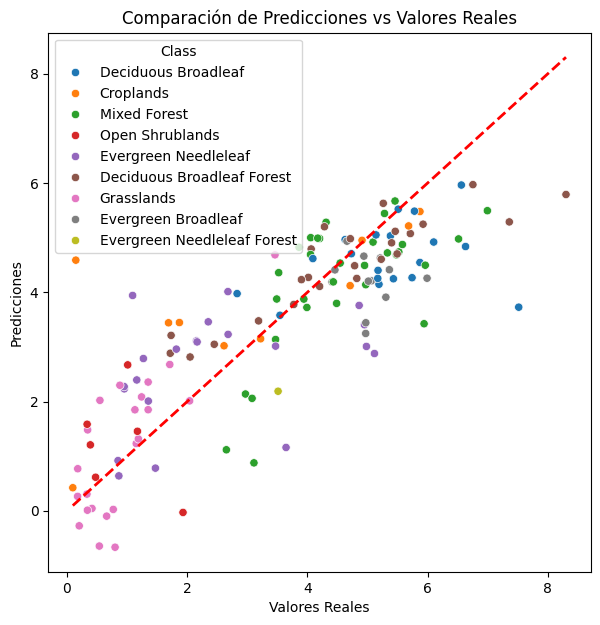

In [1509]:
plt.figure(figsize=(7, 7))

sns.scatterplot(data=df_result, x="LAI_Warren", y="pred", hue="Class")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()


### Analisis de errores

Calculamos los residuos y vemos la distribución de esos errores.

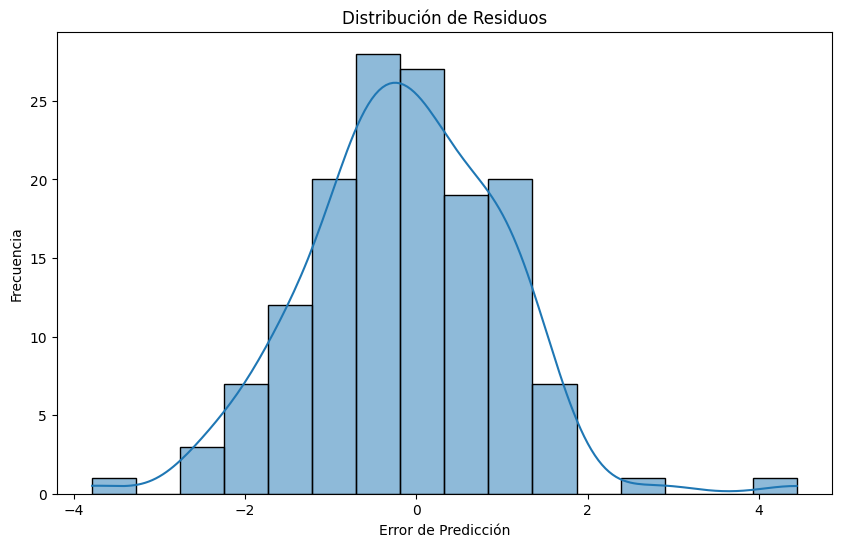

In [1510]:
# Calcular residuos
residuos = y_pred - y_test

# Visualización de residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.title('Distribución de Residuos')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.show()

Graficamos los residuos según el valor real para intentar ver patrones donde se concentran los errores.

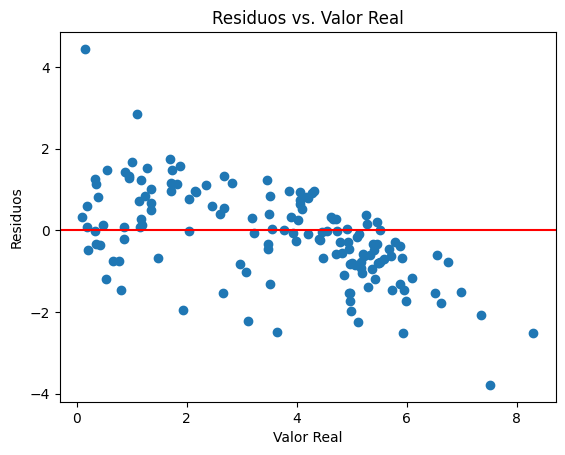

In [1511]:
# Gráfica de dispersión de residuos
plt.scatter(y_test, residuos)
plt.title('Residuos vs. Valor Real')
plt.xlabel('Valor Real')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


In [1512]:
residuos

779   -1.325422
414    0.408302
22    -1.533277
805    0.819032
500    0.955958
         ...   
277    0.071073
540   -0.789922
131    1.225033
127    1.418809
445   -0.916184
Name: LAI_Warren, Length: 146, dtype: float64

In [1513]:
test_set.columns

Index(['id', 'longitude', 'latitude', 'time', 'B2', 'B3', 'B4', 'B5', 'B6',
       'B7', 'B8', 'B8A', 'B11', 'B12', 'SCL', 'QA60', 'Site_sat', 'GBOV_ID',
       'Site', 'GROUND_DATA_PI', 'GROUND_DATA_PIs_Email', 'GBOV_Email',
       'Network', 'Elevation', 'IGBP_class', 'Lat_IS', 'Lon_IS', 'TIME_IS',
       'Version', 'up_flag', 'down_flag', 'LAI_Miller_up', 'LAI_Warren_up',
       'LAIe_Miller_up', 'LAIe_Warren_up', 'LAI_Miller_down',
       'LAI_Warren_down', 'LAIe_Miller_down', 'LAIe_Warren_down',
       'LAI_Miller_up_err', 'LAI_Warren_up_err', 'LAIe_Miller_up_err',
       'LAIe_Warren_up_err', 'clumping_Miller_up', 'clumping_Warren_up',
       'LAI_Miller_down_err', 'LAI_Warren_down_err', 'LAIe_Miller_down_err',
       'LAIe_Warren_down_err', 'clumping_Miller_down', 'clumping_Warren_down',
       'clumping_Miller_up_err', 'clumping_Warren_up_err',
       'clumping_Miller_down_err', 'clumping_Warren_down_err',
       'Warren_up_flag', 'Warren_down_flag', 'LAI_Warren', 'LAI_Warren_e

In [1514]:
test_set['LAIe_Warren'] = test_set['LAIe_Warren_up'].astype(float) + test_set['LAIe_Warren_down'].astype(float)

In [1515]:
test_set[abs(residuos) >= 2][['time','TIME_IS','delta','Site','IGBP_class','LAI_Warren','LAIe_Warren','LAI_Warren_down', 'LAI_Warren_err','LAIe_Warren_up','clumping_Warren_up','clumping_Warren_down','clumping_Warren_up_err','clumping_Warren_down_err']]

,time,TIME_IS,delta,Site,IGBP_class,LAI_Warren,LAIe_Warren,LAI_Warren_down,LAI_Warren_err,LAIe_Warren_up,clumping_Warren_up,clumping_Warren_down,clumping_Warren_up_err,clumping_Warren_down_err
225,2019-08-20 18:02:57.951,2019-08-21 06:10:00,0 days 12:07:02.049000,Niwot Ridge Mountain Research Station,Evergreen Needleleaf,3.644000,2.278000,0.354000,0.202000,1.940000,0.590000,0.950000,0.040000,0.120000
592,2021-05-18 17:00:47.206,2021-05-20 09:01:00,1 days 16:00:12.794000,Underc,Mixed Forest,3.110000,2.210000,0.520000,0.200000,1.780000,0.690000,0.830000,0.050000,0.130000
514,2018-06-01 17:12:55.191,2018-05-30 20:19:00,1 days 20:53:55.191000,University of Kansas Field Site,Deciduous Broadleaf Forest,8.300687,5.685165,4.674995,0.409225,2.454330,0.676927,0.691088,0.040597,0.061076
537,2020-06-23 17:22:56.066,2020-06-22 07:21:00,1 days 10:01:56.066000,University of Kansas Field Site,Deciduous Broadleaf Forest,7.357600,4.928011,3.133132,0.419660,2.731222,0.646524,0.701148,0.045128,0.096890
298,2021-07-17 16:15:17.899,2021-07-13 07:03:00,4 days 09:12:17.899000,Ordway Swisher Biological Station,Evergreen Needleleaf,1.092000,0.803000,0.272000,0.100000,0.550000,0.680000,0.930000,0.080000,0.130000
576,2019-06-08 17:00:52.606,2019-06-08 08:05:00,0 days 08:55:52.606000,Underc,Mixed Forest,5.940000,4.400000,1.580000,0.450000,3.280000,0.750000,0.710000,0.050000,0.140000
781,2022-08-05 16:44:28.545,2022-08-03 07:34:00,2 days 09:10:28.545000,Dead Lake,Deciduous Broadleaf,7.514435,5.022497,2.208899,0.381802,3.249966,0.612561,0.802450,0.038361,0.097824
502,2022-05-22 16:44:30.923,2022-05-25 06:52:00,2 days 14:07:29.077000,Talladega National Forest,Evergreen Needleleaf,5.114683,3.567550,0.783337,0.231975,2.934541,0.677513,0.808092,0.036629,0.124751
396,2019-09-18 16:02:22.824,2019-09-17 16:34:00,0 days 23:28:22.824000,Smithsonian Environmental Research Center,Croplands,0.147000,3.166000,0.147000,0.015000,3.030000,0.670000,0.920000,0.040000,0.120000


<Axes: xlabel='LAI_Warren_err', ylabel='Count'>

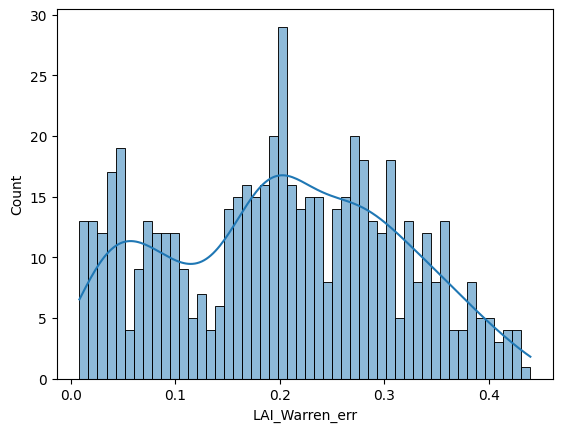

In [1516]:
sns.histplot(train_set['LAI_Warren_err'], kde=True, bins=50)

<Axes: xlabel='clumping_Warren_up_err', ylabel='Count'>

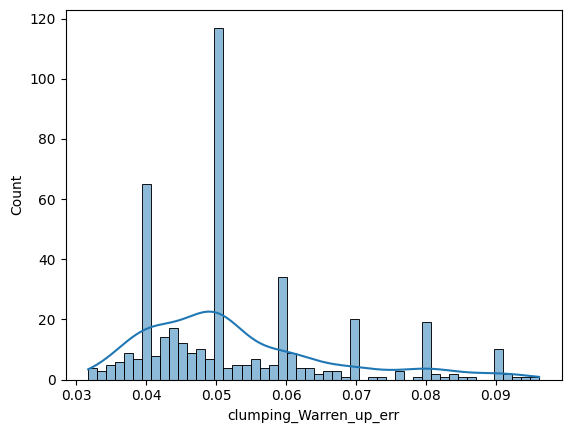

In [1517]:
sns.histplot(train_set['clumping_Warren_up_err'], kde=True, bins=50)

<Axes: xlabel='clumping_Warren_down_err', ylabel='Count'>

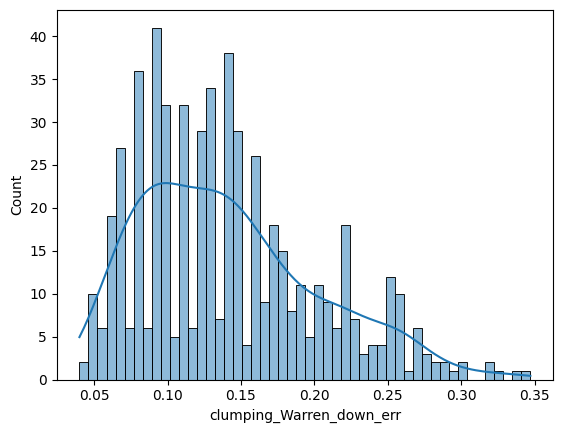

In [1518]:
sns.histplot(train_set['clumping_Warren_down_err'], kde=True, bins=50)

In [1519]:
test_set.IGBP_class.value_counts()

IGBP_class
Mixed Forest                   31
Deciduous Broadleaf Forest     24
Grasslands                     22
Evergreen Needleleaf           21
Deciduous Broadleaf            19
Evergreen Broadleaf            12
Croplands                      10
Open Shrublands                 6
Evergreen Needleleaf Forest     1
Name: count, dtype: int64

In [1520]:
train_set.IGBP_class.value_counts()

IGBP_class
Mixed Forest                   114
Deciduous Broadleaf Forest      97
Evergreen Needleleaf            86
Grasslands                      84
Deciduous Broadleaf             75
Evergreen Broadleaf             47
Croplands                       38
Open Shrublands                 23
Evergreen Needleleaf Forest      3
Name: count, dtype: int64

In [1521]:
df_cross['date_sat'] = pd.to_datetime(df_cross['date_sat'])

In [1522]:
test_set['IGBP_class'].value_counts()

IGBP_class
Mixed Forest                   31
Deciduous Broadleaf Forest     24
Grasslands                     22
Evergreen Needleleaf           21
Deciduous Broadleaf            19
Evergreen Broadleaf            12
Croplands                      10
Open Shrublands                 6
Evergreen Needleleaf Forest     1
Name: count, dtype: int64

<Axes: xlabel='IGBP_class', ylabel='Count'>

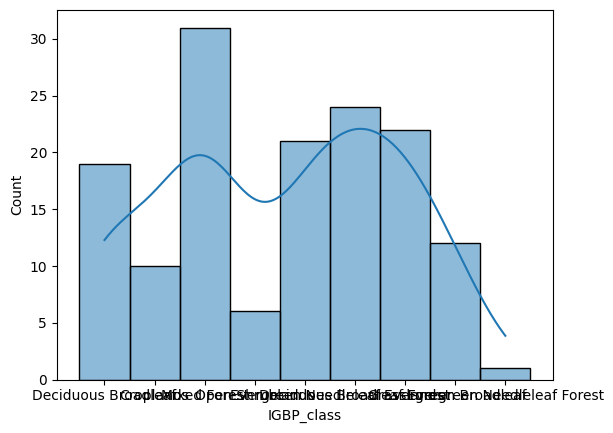

In [1523]:

sns.histplot(test_set['IGBP_class'], kde=True)

<Axes: xlabel='date_sat', ylabel='Count'>

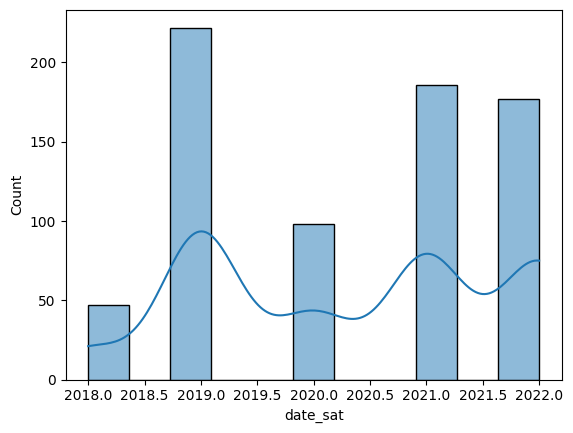

In [1524]:
sns.histplot(df_cross['date_sat'].dt.year, kde=True)

In [1525]:
df_result['residuos'] = residuos

In [1526]:
df_result['Site'] = test_set.loc[residuos.index]['Site']

In [1527]:
df_result['LAI_error'] = test_set.loc[residuos.index]['LAI_Warren_err']

In [1528]:
df_result

,LAI_Warren,pred,Class,residuos,Site,LAI_error
779,5.870797,4.545375,Deciduous Broadleaf,-1.325422,Dead Lake,0.341154
414,2.612575,3.020877,Croplands,0.408302,Smithsonian Environmental Research Center,0.171214
22,2.651195,1.117918,Mixed Forest,-1.533277,Harvard Forest,0.175294
805,0.389000,1.208032,Open Shrublands,0.819032,Disney Wilderness Preserve,0.023000
500,2.153554,3.109511,Evergreen Needleleaf,0.955958,Talladega National Forest,0.169966
...,...,...,...,...,...,...
277,0.849000,0.920073,Evergreen Needleleaf,0.071073,Ordway Swisher Biological Station,0.074000
540,5.491628,4.701706,Deciduous Broadleaf Forest,-0.789922,University of Kansas Field Site,0.277867
131,3.460000,4.685033,Grasslands,1.225033,Lajas Experimental Station,0.140000
127,0.880000,2.298809,Grasslands,1.418809,Lajas Experimental Station,0.070000


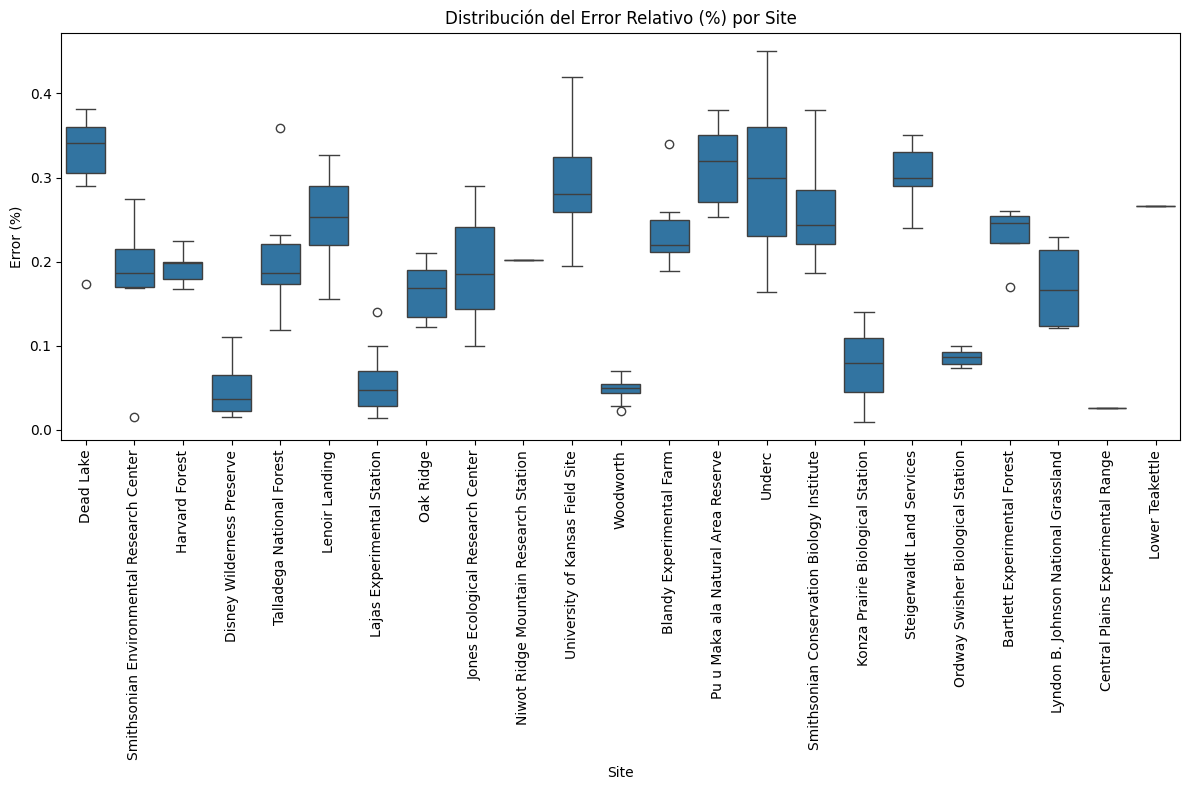

In [1529]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df_result, x='Site', y='LAI_error')
plt.xticks(rotation=90)
plt.title('Distribución del Error Relativo (%) por Site')
plt.ylabel('Error (%)')
plt.xlabel('Site')
plt.tight_layout()
plt.show()